In [145]:
import os
import numpy as np
import torch
from PIL import Image
import yaml
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch

<h1>SYNTHIA DEF</h1>

In [161]:
class Synthia(torch.utils.data.Dataset):
    def __init__(self, path_list, train = 'train', data_mode = 'rgb', scale = 1, target_width = 572, target_height = 572):
        
        self.mode = train
        self.data_mode = data_mode
        self.scale = scale
        self.target_w = target_width
        self.target_h = target_height
        
        # Get image file paths
        with open(path_list, 'r') as file:
            self.imgs = file.readlines()
            
        # Replace file paths for images with GT
        self.masks = [
            path.replace("Images/", "Masks/")
            for path in self.imgs
        ]

        # Load in learning maps for each channel
        with open("synthia_3channels.yaml", 'r') as stream:
            synthiayaml = yaml.safe_load(stream)
        self.learning_map_red = synthiayaml['learning_map_red']
        self.learning_map_green = synthiayaml['learning_map_green']
        self.learning_map_blue = synthiayaml['learning_map_blue']
        
        self.names = synthiayaml['name']
        

    def get_names(self):
        return self.names
        
    
    # Change values in the red channel since labels are encoded in red channel
    def convert_label(self, label, inverse = False):
        tempr = label[0,:,:].copy()*255
        tempg = label[1,:,:].copy()*255
        tempb = label[2,:,:].copy()*255
        
        modified = np.full((572, 572), False)
        
        for k, v in self.learning_map_red.items():
            print("k = ", k, "v = ", v)
            label[0][tempr==k] = v
            modified = np.logical_or(modified, tempr==k)
        for k, v in self.learning_map_green.items():
            label[0][np.logical_and(tempg==k, np.logical_not(modified))] = v
            
            modified = np.logical_or(modified, tempg==k)
        for k, v in self.learning_map_blue.items():
            label[0][np.logical_and(tempb==k, np.logical_not(modified))] = v 
            modified = np.logical_or(modified, tempb==k)
        return label
     
     
    def __getitem__(self, index):
        img_path = self.imgs[index].rstrip()
        mask_path = self.masks[index].rstrip()
        
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)
        
        w,h = img.size
        target_w, target_h = int(w * self.scale), int(h * self.scale)
        target_w, target_h = self.target_w, self.target_h
        img = img.resize((target_w, target_h))
        img = transforms.ToTensor()(img)
        
        mask = mask.resize((target_w, target_h))
        mask = transforms.ToTensor()(mask)
        
        mask = np.array(mask)
        # Removed because convert_label implementation needed all 3 channels (RGB)
        # mask = mask [0,:,:]
        
        mask = self.convert_label(mask)        
        mask = mask.astype(np.uint8)
        
        img = np.asarray(img)
        
        return torch.as_tensor(img.copy()).float().contiguous(), torch.as_tensor(mask.copy()).long().contiguous()
        
        
    def __len__(self):
        return len(self.imgs)

In [162]:
def get_label_names():
    with open("synthia_3channels.yaml", 'r') as stream:
        synthiayaml = yaml.safe_load(stream)
    return synthiayaml['name']

<h1>DATA LOADERS</h1>

In [163]:
from torch.utils.data import DataLoader, ConcatDataset

def setup_loaders(dataset, path_list, batch_size):
    combined_data = []
    for i in range(len(dataset)):
        if(dataset[i] == 'rellis3d'):
            data = relis3d.Relis3D(path_list[i])
            data_loader = DataLoader(data, batch_size=batch_size)
            if (len(dataset) == 1):
                return data_loader
            else:
                combined_data.append(data)
                del data_loader
                del data
        if(dataset[i] == 'semantickitti'):
            data = semantickitti.SemanticKitti(path_list[i])
            data_loader = DataLoader(data, batch_size=batch_size)
            if (len(dataset) == 1):
                return data_loader
            else:
                combined_data.append(data)
                del data_loader
                del data
        if(dataset[i] == 'cityscapes'):
            data = cityscapes.CityScapes(path_list[i])
            data_loader = DataLoader(data, batch_size=batch_size)
            if (len(dataset) == 1):
                return data_loader
            else:
                combined_data.append(data)
                del data_loader
                del data

        if(dataset[i] == 'ourdataset'):
            data = ourdataset.Dataset(path_list[i])
            data_loader = DataLoader(data, batch_size=batch_size)
            if (len(dataset) == 1):
                return data_loader
            else:
                combined_data.append(data)
                del data_loader
                del data
                
        if(dataset[i] == 'synthia'):
            data = Synthia(path_list[i])
            data_loader = DataLoader(data, batch_size=batch_size)
            if(len(dataset) == 1):
                return data_loader
            else:
                combined_data.append(data)
                del data_loader
                del data

    data_loader = DataLoader(
        ConcatDataset(combined_data),
        batch_size=batch_size, shuffle=True)
    return data_loader

<h1>TESTING DATA LOADERS</h1>

In [164]:
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
target_loader = setup_loaders(['synthia'], ['trainex.txt'], 1)
targetloader_iter = enumerate(target_loader)

In [165]:
 _, batch = targetloader_iter.__next__()
# Changed img = batch to img = batch[0] and defined mask
img = batch[0]
mask = batch[1]

k =  128 v =  1
k =  244 v =  2
k =  102 v =  4
k =  190 v =  5
k =  153 v =  6
k =  250 v =  7
k =  107 v =  9
k =  152 v =  10
k =  255 v =  13
k =  119 v =  19
k =  157 v =  20
k =  72 v =  21
k =  167 v =  22


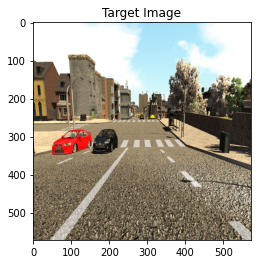

In [166]:
from torchvision import transforms
import matplotlib.pyplot as plt
plt.figure()
plt.title('Target Image')
trans = transforms.ToPILImage()
# Got rid of the one in (1, 3, 572, 572) dimensional array img[0]
img = img[0,:,:,:]
fig = plt.imshow(trans(img))

{0: 'void', 1: 'road', 2: 'sidewalk', 3: 'building', 4: 'wall', 5: 'fence', 6: 'pole', 7: 'traffic light', 8: 'traffic sign', 9: 'vegetation', 10: 'terrain', 11: 'sky', 12: 'person', 13: 'rider', 14: 'car', 15: 'truck', 16: 'bus', 17: 'train', 18: 'motorcycle', 19: 'bicycle', 20: 'road lines', 21: 'other', 22: 'road works'}


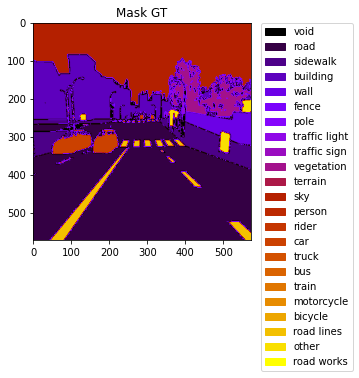

In [168]:
plt.figure()
plt.title('Mask GT')
# Changed mask[0] to img[1]
# Get rid of the one and four in (1, 4, 572, 572) in mask, making mask1 2D, picks the R channel
mask1 = mask[0,0,:,:]
values = np.unique(mask1.ravel())
names = get_label_names()
print(names)
im = plt.imshow(mask1, cmap= 'gnuplot') #had tab20, nipy_spectral, gnuplot
# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=names[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

<h1>MODELS</h1>